In [1]:
import pandas as pd
import os
import requests
import numpy as np
import json

# Gathering

Here I will read in the data from three sources.

- The twitter archive of the tweets
- A twitter api call on the tweets to get favorite count and retweet count
- The image file from the internet using the requests library

In [2]:
import tweepy

# Read in the config file with your personal keys, secrets, and tokens
with open('config_file.txt') as file:
    lines = file.readlines()
    consumer_key = lines[0].strip('\n')
    consumer_secret = lines[1].strip('\n')
    access_token = lines[2].strip('\n')
    access_secret = lines[3].strip('\n')
    
# Set up the API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [3]:
# Read in twitter archive
tweets = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Grab the image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
images = requests.get(url)

In [58]:
# Create tsv of images
with open('image_predictions.tsv', 'x') as file:
    file.write(images.text)

In [5]:
images_df = pd.read_table('image_predictions.tsv', sep = '\t')

In [6]:
file_name = 'tweet_json.txt'

In [7]:
# Create errors file
errors = open('erros.csv', 'x')
errors.write('tweet_id,deleted\n')

with open(file_name, 'x') as outfile:
    for tweet in tweets['tweet_id']:
        try:
            tweet_json = api.get_status(tweet)._json
            json.dump(tweet_json, outfile)
            outfile.write('\n')
        except Exception as e:
            print(tweet)
            errors.write(str(tweet) + ',y\n')
            
errors.close()
            


888202515573088257
873697596434513921
869988702071779329
867421006826221569
866816280283807744
861769973181624320
842892208864923648
827228250799742977
802247111496568832
775096608509886464
Rate limit reached. Sleeping for: 443
Rate limit reached. Sleeping for: 437


In [7]:
tweet_list = []

with open(file_name) as infile:
    for line in infile:
        data = json.loads(line)
        tweet_id = data['id_str']
        favorites = data['favorite_count']
        retweets = data['retweet_count']
        tweet_list.append({'tweet_id': tweet_id,
                           'favorite_count': favorites,
                           'retweet_count': retweets,
                           'deleted' : 'n'})
        
json_df = pd.DataFrame(tweet_list, columns = ['tweet_id', 'favorite_count', 'retweet_count', 'deleted'])

In [8]:
error_df = pd.read_csv('erros.csv')

In [9]:
error_df.head()

,tweet_id,deleted
0,888202515573088257,y
1,873697596434513921,y
2,869988702071779329,y
3,867421006826221569,y
4,866816280283807744,y


In [10]:
json_df = pd.concat([json_df, error_df], ignore_index = True)

In [11]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
deleted           2356 non-null object
favorite_count    2346 non-null float64
retweet_count     2346 non-null float64
tweet_id          2356 non-null object
dtypes: float64(2), object(2)
memory usage: 73.7+ KB


# Assessing

## Tidiness

- Have three data frames (tweets, json_df, images_df). Only need one
- Dog categories (pupper, etc.) should be melted into one column

## Quality

#### 'tweets' dataframe

- Some of the tweets have since been deleted and favorite/retweet count are not available
- Datatypes are incorrect (tweet_id should be of object type, timestamp should be of datetime type, dog types should be of categorical type)
- Some numerators are invalid
- Some tweets are retweets (have non-empty values for retweeted_status_id, etc.)
- Some denominators are invalid

#### 'json_df' dataframe

- Datatypes are incorrect (favorite should be of integer type, retweet count should be of integer type, tweet_id should be of object type)

#### 'images_df'

- Some tweets missing
- Datatypes are incorrect (tweet_id should be of object type, p1 should be of categorical type)
- p1 is non-descriptive column name
- Dog names have various formats
- Some aren't dogs




In [12]:
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
tweets.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
tweets.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [16]:
json_df.head()

,deleted,favorite_count,retweet_count,tweet_id
0,n,39152.0,8707.0,892420643555336193
1,n,33532.0,6388.0,892177421306343426
2,n,25276.0,4244.0,891815181378084864
3,n,42510.0,8805.0,891689557279858688
4,n,40672.0,9588.0,891327558926688256


In [17]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
deleted           2356 non-null object
favorite_count    2346 non-null float64
retweet_count     2346 non-null float64
tweet_id          2356 non-null object
dtypes: float64(2), object(2)
memory usage: 73.7+ KB


In [18]:
json_df.deleted.value_counts()

n    2346
y      10
Name: deleted, dtype: int64

In [19]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [20]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
images_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

# Cleaning

In [22]:
tweets_clean = tweets.copy()
images_clean = images_df.copy()
json_clean = json_df.copy()

## Tidiness
- Merge all dataframes together on tweet_id (convert this to a string in all dataframes first)

#### Code

In [23]:
tweets_clean.tweet_id = tweets_clean.tweet_id.astype(str)
images_clean.tweet_id = images_clean.tweet_id.astype(str)
json_clean.tweet_id = json_clean.tweet_id.astype(str)

In [24]:
master_1 = tweets_clean.merge(json_clean, on='tweet_id')

In [25]:
master_df_clean = master_1.merge(images_clean, how='left', on='tweet_id')

#### Test

In [26]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
deleted                       2

#### Define

- Now drop rows that have deleted equal to 'y'
- Additionally, drop rows that have a non-null value for retweeted_status_id (this means they are a rewteet)
- Finally, drop rows that have a non-null value for in_reply_to_status_id (this means the tweet was a reply to another tweet)

#### Code

In [27]:
master_df_clean = master_df_clean[master_df_clean.deleted == 'n']

In [28]:
master_df_clean = master_df_clean[master_df_clean.retweeted_status_id.isnull()]

In [29]:
master_df_clean = master_df_clean[master_df_clean.in_reply_to_status_id.isnull()]

#### Test

In [30]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2096 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2096 non-null object
source                        2096 non-null object
text                          2096 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2096 non-null int64
rating_denominator            2096 non-null int64
name                          2096 non-null object
doggo                         2096 non-null object
floofer                       2096 non-null object
pupper                        2096 non-null object
puppo                         2096 non-null object
deleted                       2096 non-

### Datatypes

#### Define
- Change datatypes to correct ones (tweet_id to string, timestamp to datetime, favorite/retweet count to integer, etc.) to start

#### Code

In [54]:
master_df_clean.timestamp = pd.to_datetime(master_df_clean.timestamp, 
                                        infer_datetime_format = True)
master_df_clean.favorite_count = master_df_clean.favorite_count.astype(int)
master_df_clean.retweet_count = master_df_clean.retweet_count.astype(int)

master_df_clean.rating_numerator = master_df_clean.rating_numerator.astype(float)
master_df_clean.rating_denominator = master_df_clean.rating_denominator.astype(float)

In [55]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2106
Data columns (total 28 columns):
tweet_id                      2107 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2107 non-null datetime64[ns]
source                        2107 non-null object
text                          2107 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2104 non-null object
rating_numerator              2107 non-null float64
rating_denominator            2107 non-null float64
name                          2107 non-null object
deleted                       2107 non-null object
favorite_count                2107 non-null int32
retweet_count                 2107 non-null int32
jpg_url                       1980 non-null object
img_num                      

#### Define

- Convert dog type columns (pupper, floofer, etc) into one categorical column using pandas melt method

#### Code

In [33]:
melt1 = pd.melt(master_df_clean[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']], 
                id_vars = 'tweet_id', 
                value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
                var_name = 'dog_type')

In [34]:
melt1 = melt1[melt1.value != 'None']

In [35]:
melt1.drop('value', axis = 1, inplace = True)

In [36]:
master_df_clean = master_df_clean.merge(melt1, how = 'left', on = 'tweet_id')

In [37]:
master_df_clean.drop(['doggo','floofer','pupper','puppo'], 
                     axis = 1, inplace = True)

In [38]:
master_df_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,doggo


In [39]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2106
Data columns (total 28 columns):
tweet_id                      2107 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2107 non-null datetime64[ns]
source                        2107 non-null object
text                          2107 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2104 non-null object
rating_numerator              2107 non-null float64
rating_denominator            2107 non-null float64
name                          2107 non-null object
deleted                       2107 non-null object
favorite_count                2107 non-null int32
retweet_count                 2107 non-null int32
jpg_url                       1980 non-null object
img_num                      

#### Define
- Convert dog_type to a categorical variable

#### Code

In [40]:
master_df_clean.dog_type = master_df_clean.dog_type.astype('category')

#### Test

In [41]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2106
Data columns (total 28 columns):
tweet_id                      2107 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2107 non-null datetime64[ns]
source                        2107 non-null object
text                          2107 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2104 non-null object
rating_numerator              2107 non-null float64
rating_denominator            2107 non-null float64
name                          2107 non-null object
deleted                       2107 non-null object
favorite_count                2107 non-null int32
retweet_count                 2107 non-null int32
jpg_url                       1980 non-null object
img_num                      

#### Define
- Format dog names so they are consistent (no underscores and all lowercase)

#### Code

In [42]:
master_df_clean.p1 = master_df_clean.p1.str.lower().str.replace('_',' ')
master_df_clean.p2 = master_df_clean.p2.str.lower().str.replace('_',' ')
master_df_clean.p3 = master_df_clean.p3.str.lower().str.replace('_',' ')

#### Test

In [43]:
master_df_clean[['p1','p2','p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper towel,labrador retriever,spatula
4,basset,english springer,german short-haired pointer


- Now some of the predictions in p1 (the highest confidence guess) are not dogs. When I look at stats, I will make sure to subset the data to not include those, if relevant.

#### Define
- Fix the extraction method to grab the rating numerator and denominator. Let it include decimals and not grab dates by accident.

#### Code

In [96]:
master_df_clean.rating_new = master_df_clean.text.str.extract(r'([0-9]+\.?[0-9]?\/[0-9]+)')

C:\Users\John\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [97]:
master_df_clean.rating_new = master_df_clean.rating_new.str.split('/')

In [98]:
master_df_clean[['rating_numerator', 'rating_denominator']] = pd.DataFrame(master_df_clean.rating_new.values.tolist(), 
                                                                          index = master_df_clean.index)

master_df_clean.rating_numerator = master_df_clean.rating_numerator.astype(float)
master_df_clean.rating_denominator = master_df_clean.rating_denominator.astype(float)

In [99]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2106
Data columns (total 28 columns):
tweet_id                      2107 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2107 non-null datetime64[ns]
source                        2107 non-null object
text                          2107 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2104 non-null object
rating_numerator              2107 non-null float64
rating_denominator            2107 non-null float64
name                          2107 non-null object
deleted                       2107 non-null object
favorite_count                2107 non-null int32
retweet_count                 2107 non-null int32
jpg_url                       1980 non-null object
img_num                      

#### Define
- Rename p1, p2, p3 columns to dog_guess_1, dog_guess_2, dog_guess_3 for clarity

#### Code

In [100]:
master_df_clean.rename(index=str, columns={'p1':'dog_guess_1','p2':'dog_guess_2','p3':'dog_guess_3'}, inplace=True)

#### Test

In [101]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2107 entries, 0 to 2106
Data columns (total 28 columns):
tweet_id                      2107 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2107 non-null datetime64[ns]
source                        2107 non-null object
text                          2107 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2104 non-null object
rating_numerator              2107 non-null float64
rating_denominator            2107 non-null float64
name                          2107 non-null object
deleted                       2107 non-null object
favorite_count                2107 non-null int32
retweet_count                 2107 non-null int32
jpg_url                       1980 non-null object
img_num                       1980

- The tweets that are missing from the images dataframe can be considered unrecoverable data. It would be possible to write a script to loop through the non-deleted tweets and grab the images, but since the images aren't necessary for the visualizations and analysis that I am going to do, I will simply use the ones I have.

# Final Steps
- Finally, we will write the new master dataframe to its own file.

In [102]:
master_df_clean.to_csv('twitter_archive_master.csv', index = False)

# Analysis

In [104]:
import matplotlib.pyplot as plt
% matplotlib inline

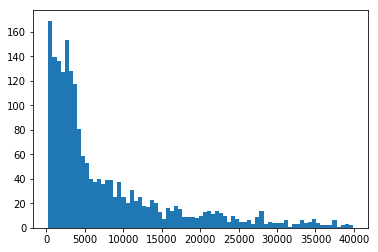

In [105]:
plt.hist(master_df_clean.favorite_count, 75,
         range=[np.percentile(master_df_clean.favorite_count, 2.5), np.percentile(master_df_clean.favorite_count, 97.5)]);

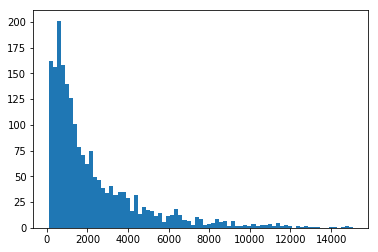

In [106]:
plt.hist(master_df_clean.retweet_count, 75,
         range=[np.percentile(master_df_clean.retweet_count, 2.5), np.percentile(master_df_clean.retweet_count, 97.5)]);

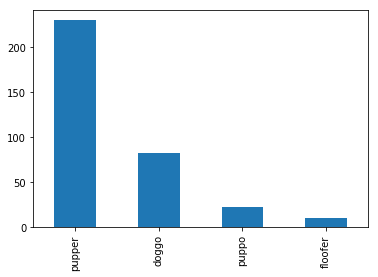

In [107]:
master_df_clean.dog_type.value_counts().plot(kind='bar');
plt.savefig('dog_types.png', bbox_inches='tight')

In [108]:
master_df_clean.groupby('dog_type')[['favorite_count', 'retweet_count']].describe()

favorite_count                                                        \
                  count          mean           std     min      25%      50%   
dog_type                                                                        
doggo              83.0  17671.036145  20112.120330  2554.0  7417.00  11394.0   
floofer            10.0  11530.700000  10125.334892  1593.0  4341.75   8565.5   
pupper            230.0   7452.678261  11352.178345   267.0  2423.50   3394.0   
puppo              23.0  23730.043478  30229.620287  3239.0  6975.50  15226.0   

                             retweet_count                                    \
               75%       max         count         mean           std    min   
dog_type                                                                       
doggo     18846.50  129424.0          83.0  6361.084337  11315.271039  710.0   
floofer   15806.25   32896.0          10.0  4012.400000   5170.802951  490.0   
pupper     8117.25  124497.0         230.0  2530.717391   3939.584324   26.0   
puppo     23030.00  143969.0          23.0  7373.826087  10637.149023  703.0   

                                            
              25%     50%     75%      max  
dog_type                                    
doggo     2021.00  2903.0  5198.5  78274.0  
floofer   1364.50  2832.5  3670.5  18136.0  
pupper     717.25  1250.5  2547.0  36818.0  
puppo     1697.00  3180.0  8794.5  49747.0

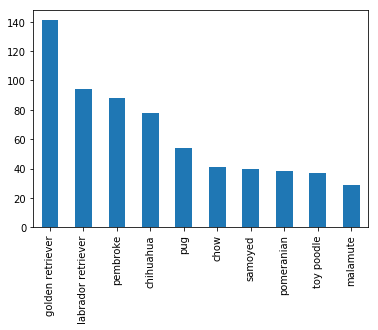

In [109]:
master_df_clean[master_df_clean.p1_dog == True].dog_guess_1.value_counts().nlargest(10).plot(kind='bar');
plt.savefig('dogbreeds.png', dpi = 250, bbox_inches='tight')

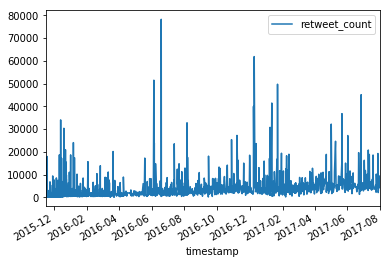

In [110]:
master_df_clean.plot(x = 'timestamp', y = 'retweet_count');

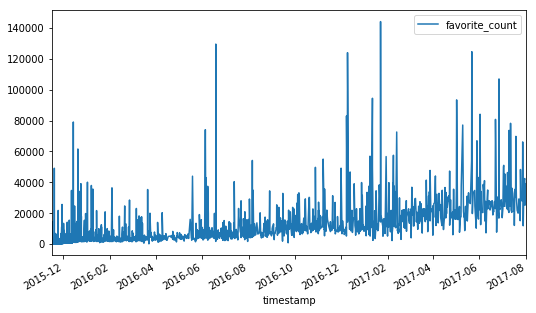

In [111]:
master_df_clean.plot(x = 'timestamp', y = 'favorite_count', figsize=(8.5, 5.0));
plt.savefig('favorite_time.png', dpi = 250, bbox_inches = 'tight')
